In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import csaps
import math
import numpy as np 
import torch             
import torch.nn as nn    
import torch.nn.functional as F   
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import imageio 
from early_stopping import EarlyStopping
import os, gc
import random 
import pynvml
import multiprocessing
import itertools
import subprocess
import gc
from functools import partial
from pandarallel import pandarallel
import rpy2.robjects as robjects
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfe
import cartopy.crs as ccrs 
import xarray as xr
import imageio
import numpy as np
import pandas as pd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.colors as mcolors
import matplotlib as mpl
from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True
def worker_init_fn(worker_id):
    random.seed(123 + worker_id)

def get_gpu_memory(device_id):
    try:
        output = subprocess.check_output(["nvidia-smi", "--id={}".format(device_id), "--query-gpu=memory.used,memory.total", "--format=csv,nounits,noheader"])
        memory_used, memory_total = map(int, output.decode("utf-8").strip().split("\n")[0].split(","))
        return memory_used, memory_total
    except Exception as e:
        print(e)
        return None, None

def get_free_gpu():
    device_ids = list(range(torch.cuda.device_count()))
    memory_usages = []
    for device_id in device_ids:
        memory_used, memory_total = get_gpu_memory(device_id)
        if memory_used is not None and memory_total is not None:
            memory_free = memory_total - memory_used
            memory_usages.append((device_id, memory_free))
        print(memory_total,memory_usages)
    if len(memory_usages) > 0:
        best_device_id = sorted(memory_usages, key=lambda x: x[1])[len(device_ids)-1][0]
        device = torch.device(f"cuda:{best_device_id}")
        return device
    else:
        return None


class Args:
    def __init__(self, batch_size=10, lr =0.001, nepoch = 500, patience = 10, wide = 100, depth = 5, n_train=1, m_train=1) -> None:
        self.batch_size = batch_size
        self.lr = lr
        self.nepoch = nepoch 
        self.patience = patience 
        self.wide = wide 
        self.depth = depth 
        self.biaoji = "salwide" + str(wide) + "depth" + str(depth) + "n" + str(n_train) + "m" + str(m_train)
        self.n_train = n_train
        self.m_train = m_train


class EarlyStopping():
    def __init__(self, save_path, args, verbose=False, delta=0):
        self.save_path = save_path 
        self.patience = args.patience 
        self.verbose = verbose 
        self.counter = 0 
        self.best_score = None 
        self.early_stop = False 
        self.val_loss_min = np.Inf 
        self.delta = delta 

    def __call__(self, model, train_loss, valid_loss, args, seed):

        score = -valid_loss 

        if self.best_score is None: 
            self.best_score = score 
            self.save_checkpoint(model, train_loss, valid_loss, args, seed) 
        elif score < self.best_score + self.delta: 
            self.counter += 1 
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}') 
            if self.counter >= self.patience: 
                self.early_stop = True 
        else:
            self.best_score = score
            self.save_checkpoint(model, train_loss, valid_loss,  args, seed)
            self.counter = 0

    def save_checkpoint(self, model, train_loss, valid_loss,  args, seed):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...') 
        torch.save(model, os.path.join(self.save_path, 'best' + str(seed) + args.biaoji +'network.pth') )
        torch.save(train_loss, os.path.join(self.save_path, 'best'+ str(seed) + args.biaoji +'train_loss.pth')) 
        torch.save(valid_loss, os.path.join(self.save_path, 'best'+ str(seed) + args.biaoji +'valid_loss.pth')) 

        self.val_loss_min = valid_loss
    


class Dataset_repeatedmeasurement(Dataset): 
    def __init__(self, x, y) -> None: 
        super().__init__()
        self.x = x 
        self.y = y 

    def __len__(self) -> int: 
        return len(self.x) 
    
    def __getitem__(self, index): 
        return {
            "x" : self.x[index], 
            "y" : self.y[index]
        }


class happynet(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, n_layer): 
        super().__init__()
        if n_layer == 3: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output), 
            )
        elif n_layer == 2: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output), 
            )    
        elif n_layer == 4: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output), 
            )
        elif n_layer == 5: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 6: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 7: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 8: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 9: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        elif n_layer == 10: 
            self.net = nn.Sequential(
                nn.Linear(n_feature, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),  
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden), 
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(),
                nn.Linear(n_hidden, n_output),
            )
        else: 
            print("Error! the depth is not in 3-10")
    
    #定义前向运算
    def forward(self, x):
        k = self.net(x)
        return k

In [2]:
def GPUstrain2(x, y, x_valid, y_valid, args,seed,nocuda): 
    x_dim = 2
    if nocuda == 0:
        device = torch.device("cuda:0")
    if nocuda == 1:
        device = torch.device("cuda:1")
    if nocuda == 100:
        device = get_free_gpu()
    if nocuda == -1:
        device = torch.device("cpu")
    if nocuda == 9:
        device = torch.device("cuda")

    net = happynet(n_feature=x_dim, n_hidden=args.wide, n_output=1, n_layer=args.depth).to(device)
    nepoch = args.nepoch
    
    optimizer=torch.optim.Adam(net.parameters(), lr=args.lr, betas=(0.90, 0.999), eps=1e-8, weight_decay=0., amsgrad=False,) 
    loss_func=nn.MSELoss() 
    train_epochs_loss = [] 
    valid_epochs_loss = [] 
    x = x.reshape(-1,x_dim)
    y = y.reshape(-1)

    g = torch.Generator()
    g.manual_seed(20000331)
    train_dataset = Dataset_repeatedmeasurement(x,y)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, 
                                  shuffle=True, 
                                  worker_init_fn=worker_init_fn, 
                                  generator=g)

    x=torch.from_numpy(x).float() 
    y=torch.from_numpy(y).float() 
    x_valid=torch.from_numpy(x_valid).float().to(device) 
    y_valid=torch.from_numpy(y_valid).float().to(device) 

    xp = x.to(device)
    yp = y.to(device)

    save_path = "./resultsv" 
    early_stopping = EarlyStopping(save_path,args=args)

    for epoch in range(nepoch): 
        net.train()
        train_epoch_loss = []

        # =========================train=========================
        for idx, traindata in enumerate(train_dataloader):
            x_train = traindata["x"]
            y_train = traindata["y"]
            x_train=torch.Tensor(x_train).float().view(-1,1,x_dim).to(device) 
            y_train=torch.Tensor(y_train).float().to(device) 
            outputs=net(x_train) 
            loss=loss_func(outputs.view(-1),y_train.view(-1).float())
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 
            train_epoch_loss.append(loss.item())

        del outputs, loss

        train_epochs_loss.append(np.average(train_epoch_loss))

        # =========================valid=========================
        with torch.no_grad():
            net.eval() 

            valid_predict=net(x_valid.view(-1,1,x_dim))
            valid_y_pre=valid_predict.view(-1).detach()
            valid_y_pre=torch.Tensor(valid_y_pre).float()
            loss_valid=loss_func(valid_y_pre, y_valid.view(-1).float())
            valid_epochs_loss.append(loss_valid.item())

            p_predict=net(xp.view(-1,1,x_dim))
            p_y_pre=p_predict.view(-1).detach()
            p_y_pre=torch.Tensor(p_y_pre).float()
            loss_p=loss_func(p_y_pre, yp.view(-1).float())

        print("epoch = {}, training loss = {}, validation loss = {}".format(epoch, loss_p, loss_valid))#, error_test
        if epoch > 10:
            early_stopping(net, np.average(train_epoch_loss), loss_valid, args,seed)
            if early_stopping.early_stop: 
                print("Early stopping")
                break 
        del valid_predict, valid_y_pre, loss_valid
    gc.collect()

    return net, train_epochs_loss, valid_epochs_loss 

In [3]:
nnn_vec = [40,120]
mma = [50,100,150]
res = np.zeros(shape=(len(nnn_vec), len(mma), 3))

for nnnind in range(len(nnn_vec)):
    nnn = nnn_vec[nnnind]
    n_train = nnn
    n_valid = math.ceil(nnn * 0.25)
    seed = 321
    torch.manual_seed(seed) 
    np.random.seed(seed) 
    random.seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    zong = 180
    randind = list(range(zong))
    random.shuffle(randind)
    train_ind = [randind[i] for i in range(0, math.ceil(zong * 0.8 ))]
    valid_ind = [randind[i] for i in range(math.ceil(zong * 0.8), math.ceil(zong))]
    train_ind = [randind[i] for i in range(n_train)]
    valid_ind = [randind[i] for i in range(n_valid)]

    for mind in range(len(mma)):
        m = mma[mind]
        m_train = m
        m_valid = m

        traindata = np.empty(shape=(0,3))
        validdata = np.empty(shape=(0,3))

        for ind in train_ind: 
            year = 2003 + ind//9 
            numon = ind % 9 + 1 
            robjects.r['load']("./data/year" + str(year) + "day" + str(numon) + ".Rdata") 
            dz = np.array(robjects.r['data2sal'])
            mr = min(len(dz), m_train)
            train_ind_m = list(range(len(dz)))
            random.shuffle(train_ind_m)
            traindata = np.append(traindata, dz[train_ind_m[:mr]], axis=0) 

        for ind in valid_ind: 
            year = 2003 + ind//9 
            numon = ind % 9 + 1 
            robjects.r['load']("./data/year" + str(year) + "day" + str(numon) + ".Rdata") 
            dz = np.array(robjects.r['data2sal'])
            mr = min(len(dz), m_valid)
            train_ind_m = list(range(len(dz)))
            random.shuffle(train_ind_m)
            validdata = np.append(validdata, dz[train_ind_m[:mr]], axis=0) 

        traindata = traindata[np.isfinite(traindata[:,1]),]
        validdata = validdata[np.isfinite(validdata[:,1]),]

        for i in range(len(traindata[:,0])):
            if traindata[i,0] < 0:
                traindata[i,0] = traindata[i,0] + 360
            traindata[i,0] = (traindata[i,0] - 100)/180
            traindata[i,1] = (traindata[i,1] + 60)/120

        for i in range(len(validdata[:,0])):
            if validdata[i,0] < 0:
                validdata[i,0] = validdata[i,0] + 360
            validdata[i,0] = (validdata[i,0] - 100)/180
            validdata[i,1] = (validdata[i,1] + 60)/120

        x_train = traindata[:,:2].reshape(-1,2)
        y_train = traindata[:,2].reshape(-1)
        x_valid = validdata[:,:2].reshape(-1,2)
        y_valid = validdata[:,2].reshape(-1)

        nm = len(x_train)
        print(nm)

        batch_size= 64
        lr = 0.0005

        nocuda = 9
        seed = nm
        torch.manual_seed(seed) 
        np.random.seed(seed) 
        random.seed(seed) 
        torch.cuda.manual_seed_all(seed) 

        args = Args(lr=lr, wide=50, depth = 2, batch_size= batch_size)
        GPUstrain2(x=x_train,y=y_train,x_valid = x_valid,y_valid=y_valid, args=args,seed = seed, nocuda = nocuda)

        a = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'train_loss.pth')
        b = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'valid_loss.pth')
        net0 = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'network.pth')
        a = np.expand_dims(a , 0)
        b = np.expand_dims(b.cpu(), 0)
        c0 = np.r_[a,b,0]

        args = Args(lr=lr, wide=100, depth = 3, batch_size= batch_size)
        GPUstrain2(x=x_train,y=y_train,x_valid = x_valid,y_valid=y_valid, args=args,seed = seed, nocuda = nocuda)
        a = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'train_loss.pth')
        b = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'valid_loss.pth')
        net1 = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'network.pth')
        a = np.expand_dims(a , 0)
        b = np.expand_dims(b.cpu(), 0)
        c1 = np.r_[a,b,1]

        args = Args(lr=lr, wide=200, depth = 4, batch_size= batch_size)
        GPUstrain2(x=x_train,y=y_train,x_valid = x_valid,y_valid=y_valid, args=args,seed = seed, nocuda = nocuda)
        a = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'train_loss.pth')
        b = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'valid_loss.pth')
        net2 = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'network.pth')
        a = np.expand_dims(a , 0)
        b = np.expand_dims(b.cpu(), 0)
        c2 = np.r_[a,b,2]

        args = Args(lr=lr, wide=400, depth = 5, batch_size= batch_size)
        GPUstrain2(x=x_train,y=y_train,x_valid = x_valid,y_valid=y_valid, args=args,seed = seed, nocuda = nocuda)
        a = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'train_loss.pth')
        b = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'valid_loss.pth')
        net3 = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'network.pth')
        a = np.expand_dims(a , 0)
        b = np.expand_dims(b.cpu(), 0)
        c3 = np.r_[a,b,3]

        args = Args(lr=lr, wide=600, depth = 6, batch_size= batch_size)
        GPUstrain2(x=x_train,y=y_train,x_valid = x_valid,y_valid=y_valid, args=args,seed = seed, nocuda = nocuda)
        a = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'train_loss.pth')
        b = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'valid_loss.pth')
        net4 = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'network.pth')
        a = np.expand_dims(a , 0)
        b = np.expand_dims(b.cpu(), 0)
        c4 = np.r_[a,b,4]

        args = Args(lr=lr, wide=800, depth = 6, batch_size= batch_size)
        GPUstrain2(x=x_train,y=y_train,x_valid = x_valid,y_valid=y_valid, args=args,seed = seed, nocuda = nocuda)
        a = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'train_loss.pth')
        b = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'valid_loss.pth')
        net5 = torch.load('./resultsv/best'+ str(seed) + args.biaoji +'network.pth')
        a = np.expand_dims(a , 0)
        b = np.expand_dims(b.cpu(), 0)
        c5 = np.r_[a,b,5]

        p = np.r_[np.expand_dims(c0, 0),np.expand_dims(c1, 0),np.expand_dims(c2, 0),np.expand_dims(c3, 0),np.expand_dims(c4, 0),np.expand_dims(c5, 0)]
        ind = np.argmin(p[:,1])
        torch.save( eval("net"+str(ind)) , os.path.join("./bestnet/", 'bestn'+str(n_train)+"m"+str(m_train)+'salnet.pth'))
        np.save("./bestnet/n"+str(n_train)+"m"+str(m_train)+"p.npy",p)
 

1962
epoch = 0, training loss = 1198.6844482421875, validation loss = 1202.1029052734375
epoch = 1, training loss = 1178.29736328125, validation loss = 1181.8563232421875
epoch = 2, training loss = 1157.68212890625, validation loss = 1161.406494140625
epoch = 3, training loss = 1136.1153564453125, validation loss = 1140.0220947265625
epoch = 4, training loss = 1112.8885498046875, validation loss = 1116.995849609375
epoch = 5, training loss = 1087.3427734375, validation loss = 1091.6905517578125
epoch = 6, training loss = 1059.0032958984375, validation loss = 1063.6771240234375
epoch = 7, training loss = 1027.5159912109375, validation loss = 1032.5311279296875
epoch = 8, training loss = 992.6763916015625, validation loss = 998.0550537109375
epoch = 9, training loss = 954.406982421875, validation loss = 960.1671752929688
epoch = 10, training loss = 913.1031494140625, validation loss = 919.2654418945312
epoch = 11, training loss = 868.98974609375, validation loss = 875.5431518554688
epoch

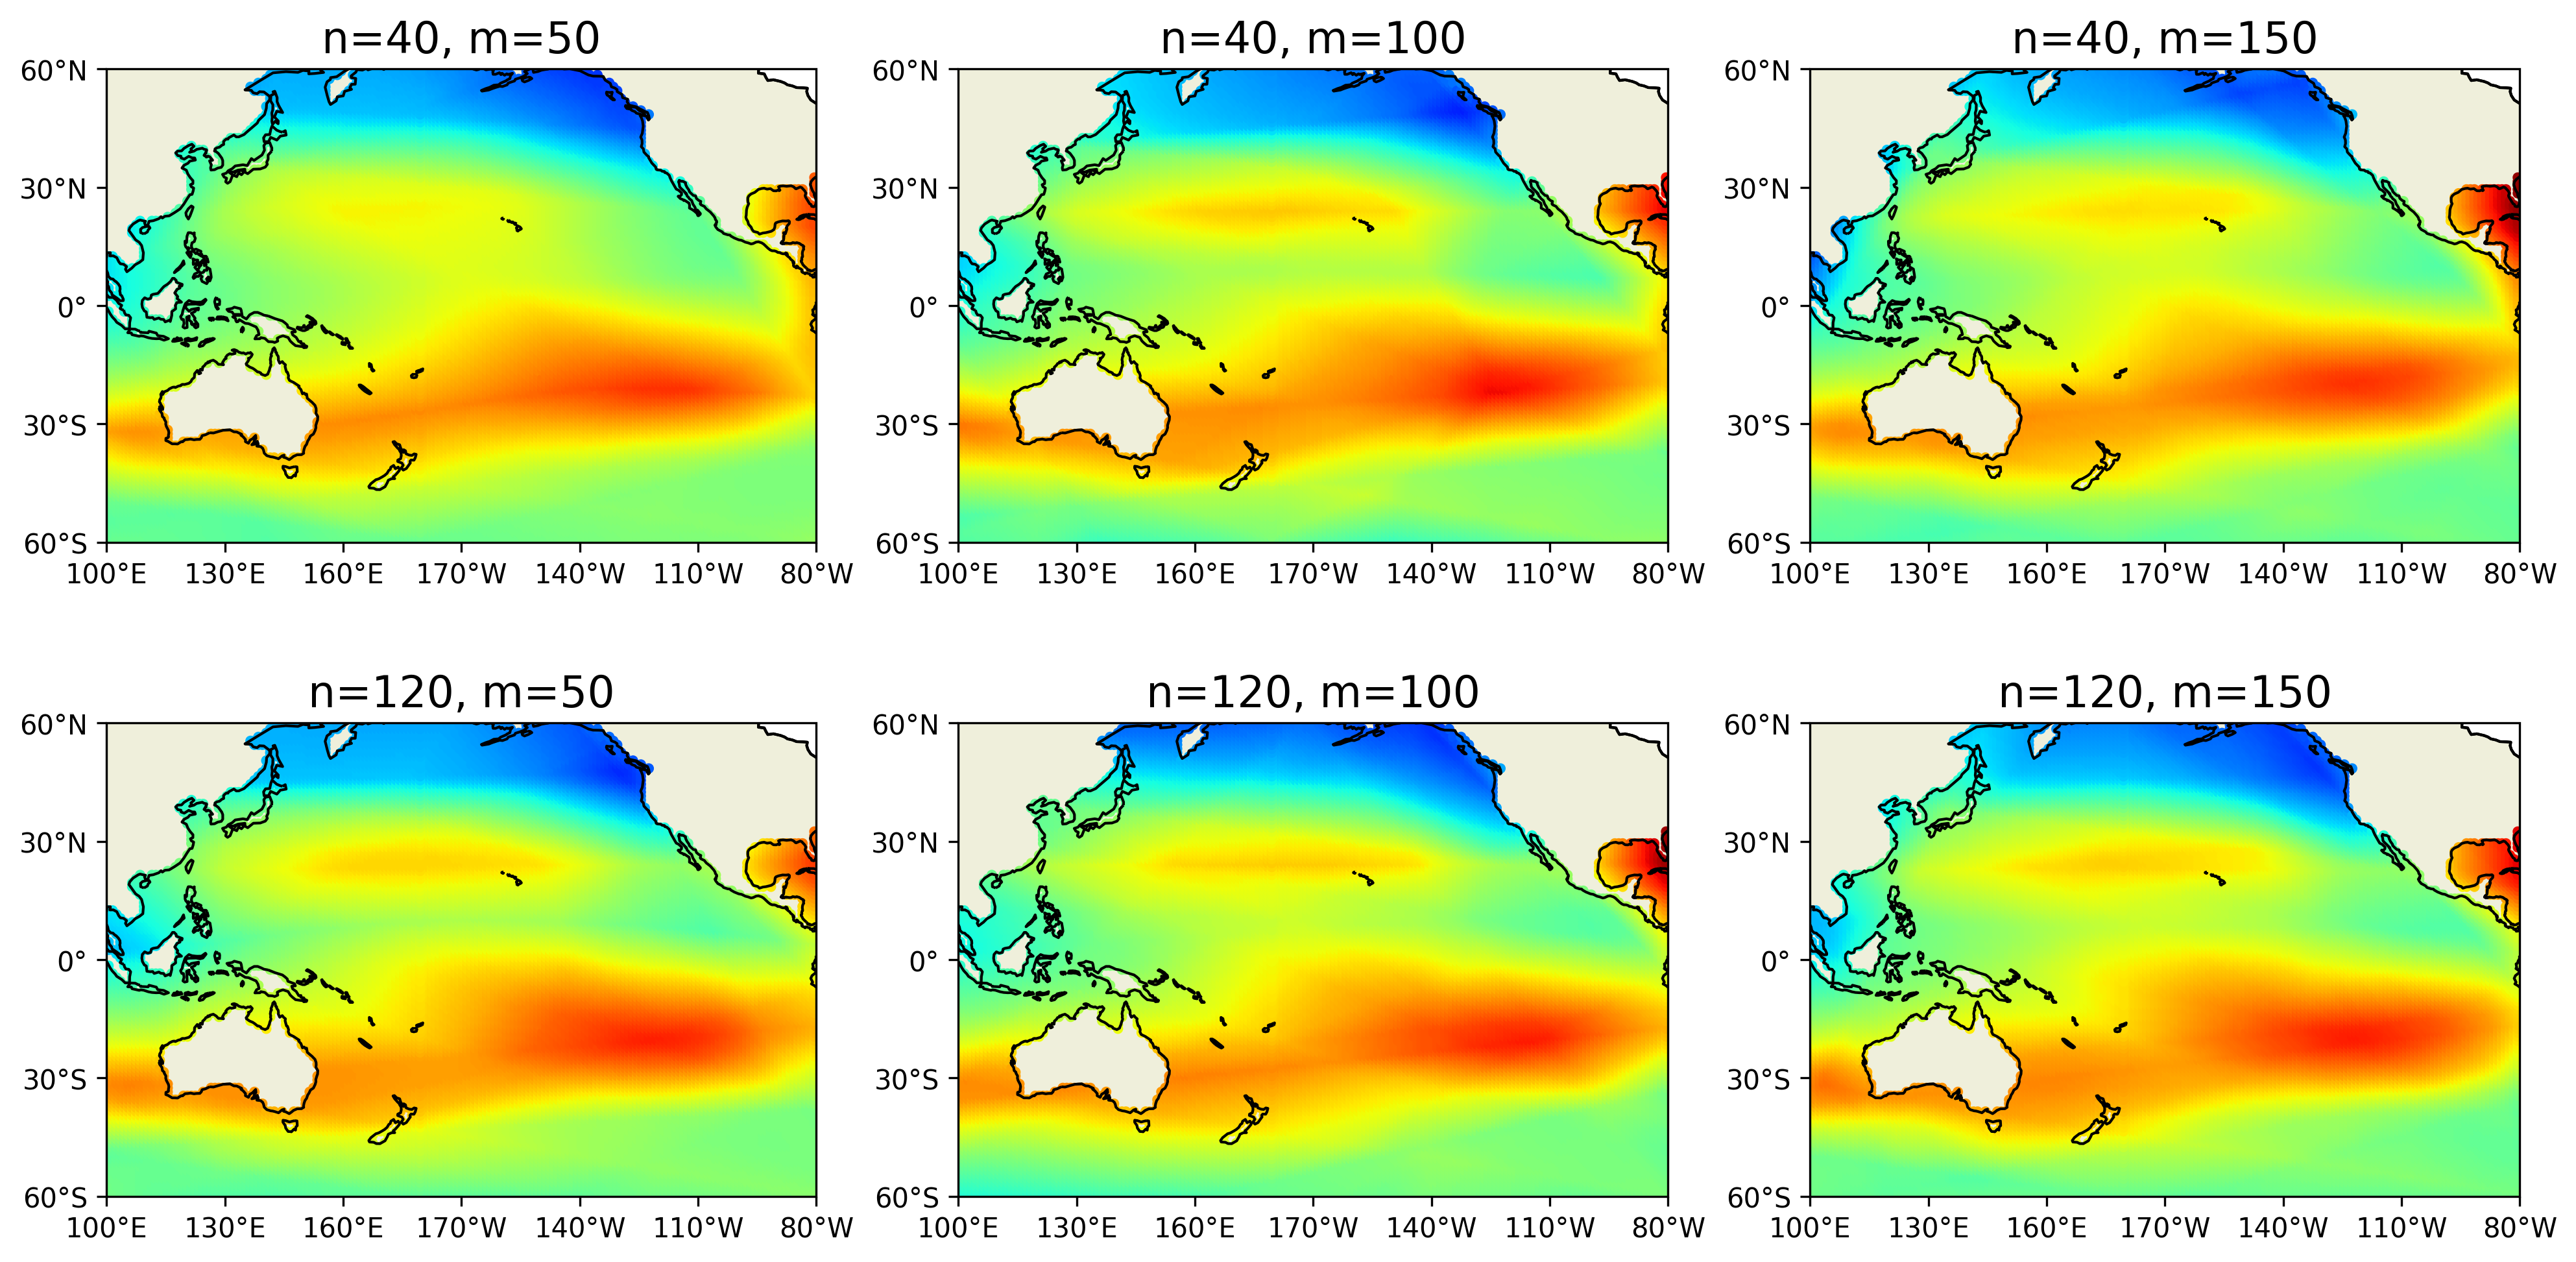

In [6]:
from global_land_mask import globe
def subplotv(ax,n,m):
    m_train = m
    nnn = n
    n_train = nnn

    lat = np.arange(-59.5, 60, 1)
    long = np.hstack((np.arange(-179.5, -80, 1), np.arange(100.5, 180, 1)))
    grid_lat, grid_long = np.meshgrid(lat,long)
    grid_lat = grid_lat.reshape(-1)
    grid_long = grid_long.reshape(-1)
    panding = (globe.is_land(grid_lat,grid_long) == False)
    for i in range(len(grid_long)):
        if grid_long[i] > -100 and grid_long[i] <0 and grid_lat[i] > 45: 
            panding[i] = False
    grid_lat = grid_lat[panding]
    grid_long = grid_long[panding]
    grid_lat1 = grid_lat.copy()
    grid_long1 = grid_long.copy()
    for i in range(len(grid_long)):
        if grid_long1[i] < 0:
            grid_long1[i] = grid_long1[i] + 360
            grid_long[i] = grid_long[i] + 360
        grid_long1[i] = (grid_long1[i] - 100)/180
        grid_lat1[i] = (grid_lat1[i] + 60)/120
    gridt = torch.from_numpy(np.dstack((grid_long1,grid_lat1))).float().cuda()
    
    net = torch.load("./bestnet/bestn"+str(n_train)+"m"+str(m_train)+'salnet.pth').cuda()
    grid_predict=net(gridt.view(-1,1,2))
    grid_y_pre=grid_predict.view(-1).detach()
    grid_y_pre=torch.Tensor(grid_y_pre).float()
    grid_y = np.array(grid_y_pre.cpu())

    extend=[-80, 100,-60, 60] 
    ax.set_extent(extend,crs=ccrs.PlateCarree(central_longitude=180)) 
    ax.add_feature(cfe.LAND,edgecolor='black')
    ax.set_xticks(np.array([-80,-110,-140,-170,160,130,100]), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-60,90,30), crs=ccrs.PlateCarree(central_longitude=180))
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines() 
    
    ax.set_title("n="+str(n_train)+", m="+str(m_train),size = 16)
    levels = np.arange(33,38, 0.001) 
    cmap = "jet"
    cmo = plt.cm.get_cmap(cmap)
    cs, k = list(), 256/cmo.N
    for i in range(cmo.N):
        c = cmo(i)
        for j in range(int(i*k), int((i+1)*k)):
            cs.append(c) 
    cs = np.array(cs) 
    h = ax.scatter(grid_long-180, grid_lat, s = 8, color = cs[np.uint8(255*(grid_y-31)/6.2)])

fig, ((ax1, ax2, ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3, dpi=300,figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

h=subplotv(ax1,40,50)
h=subplotv(ax2,40,100)
h=subplotv(ax3,40,150)
h=subplotv(ax4,120,50)
h=subplotv(ax5,120,100)
h=subplotv(ax6,120,150)
plt.show()